In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/hate-speech-and-offensive-language-detection")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'hate-speech-and-offensive-language-detection' dataset.
Path to dataset files: /kaggle/input/hate-speech-and-offensive-language-detection


In [27]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, SpatialDropout1D
from tensorflow.keras.layers import LSTM, Dense, Dropout

import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

X = df['tweet']
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
import os
import pandas as pd

file_path = os.path.join(path, "train.csv")
df = pd.read_csv(file_path)
df.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


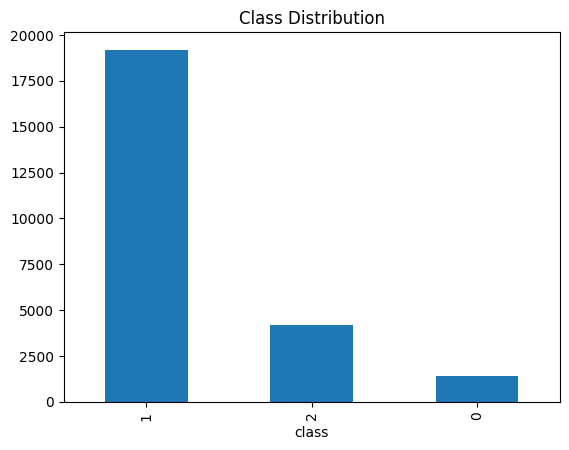

In [15]:
df['class'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.show()


In [16]:
import nltk
from nltk.stem import PorterStemmer
import string

stemmer = PorterStemmer()

def clean(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = text.split()
    text = [stemmer.stem(word) for word in text]
    return " ".join(text)

df["tweet"] = df["tweet"].apply(clean)

In [19]:
tokenizer = Tokenizer(num_words=5000, oov_token="<UNK>")
tokenizer.fit_on_texts(df["tweet"])

sequences = tokenizer.texts_to_sequences(df["tweet"])

X = pad_sequences(
    sequences,
    maxlen=100,
    padding="post",
    truncating="post"
)

In [22]:
y = pd.get_dummies(y).values

In [26]:
import tensorflow as tf

X_train_processed, X_test_processed, y_train_processed, y_test_processed = train_test_split(X, y, test_size=0.2, random_state=42)

# The 'y' variable is already one-hot encoded from the previous step (LxYvqVgW2DL_)
# so we don't need to apply to_categorical here again. If y was not one-hot encoded,
# we would use something like:
# num_classes = len(df['class'].unique())
# y_train_processed = tf.keras.utils.to_categorical(y_train_processed, num_classes=num_classes)
# y_test_processed = tf.keras.utils.to_categorical(y_test_processed, num_classes=num_classes)

print(f"Shape of X_train_processed: {X_train_processed.shape}")
print(f"Shape of X_test_processed: {X_test_processed.shape}")
print(f"Shape of y_train_processed: {y_train_processed.shape}")
print(f"Shape of y_test_processed: {y_test_processed.shape}")

Shape of X_train_processed: (19826, 100)
Shape of X_test_processed: (4957, 100)
Shape of y_train_processed: (19826, 3)
Shape of y_test_processed: (4957, 3)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


In [24]:
model_cnn = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_cnn = model_cnn.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test, y_test)
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8448 - loss: 0.4424 - val_accuracy: 0.8955 - val_loss: 0.2820
Epoch 2/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9246 - loss: 0.2133 - val_accuracy: 0.8899 - val_loss: 0.2952
Epoch 3/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9549 - loss: 0.1281 - val_accuracy: 0.8796 - val_loss: 0.3770
Epoch 4/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9780 - loss: 0.0632 - val_accuracy: 0.8894 - val_loss: 0.5344
Epoch 5/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9894 - loss: 0.0336 - val_accuracy: 0.8820 - val_loss: 0.5832


In [30]:
model_lstm = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    SpatialDropout1D(0.2),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model_lstm.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_lstm = model_lstm.fit(
    X_train_processed, y_train_processed,
    epochs=5,
    batch_size=32,
    validation_data=(X_test_processed, y_test_processed)
)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


620/620 ━━━━━━━━━━━━━━━━━━━━ 221s 340ms/step - accuracy: 0.7662 - loss: 0.6890 - val_accuracy: 0.7730 - val_loss: 0.6654
Epoch 2/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 211s 340ms/step - accuracy: 0.7770 - loss: 0.6582 - val_accuracy: 0.7730 - val_loss: 0.6656
Epoch 3/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 210s 339ms/step - accuracy: 0.7721 - loss: 0.6707 - val_accuracy: 0.7730 - val_loss: 0.6694
Epoch 4/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 211s 341ms/step - accuracy: 0.7706 - loss: 0.6707 - val_accuracy: 0.7730 - val_loss: 0.6658
Epoch 5/5
620/620 ━━━━━━━━━━━━━━━━━━━━ 211s 340ms/step - accuracy: 0.7763 - loss: 0.6601 - val_accuracy: 0.7730 - val_loss: 0.6662


In [50]:
model_cnn_lstm = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),

    Conv1D(filters=128, kernel_size=5, activation='relu'),
    SpatialDropout1D(0.2),

    LSTM(128, dropout=0.2, recurrent_dropout=0.2),

    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model_cnn_lstm.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_cnn_lstm = model_cnn_lstm.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test, y_test)
)


ValueError: Invalid dtype: object

In [39]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def bert_encode(texts):
    return bert_tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

train_encodings = bert_encode(X_train)
test_encodings = bert_encode(X_test)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [40]:
class HateDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.tolist()

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = HateDataset(train_encodings, y_train)
test_dataset = HateDataset(test_encodings, y_test)


In [41]:
bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3
)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [43]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",        # Fixed: 'evaluation_strategy' is now 'eval_strategy'
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    logging_dir="./logs",
    save_strategy="no"
)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


In [44]:
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()


Epoch,Training Loss,Validation Loss
1,0.310025,0.295378
2,0.262378,0.320963


TrainOutput(global_step=4958, training_loss=0.3128106277668943, metrics={'train_runtime': 541.9095, 'train_samples_per_second': 73.171, 'train_steps_per_second': 9.149, 'total_flos': 1079975745521064.0, 'train_loss': 0.3128106277668943, 'epoch': 2.0})

In [47]:
preds = trainer.predict(test_dataset)
bert_preds = np.argmax(preds.predictions, axis=1)

print("BERT Accuracy:", accuracy_score(y_test, bert_preds))
print(classification_report(y_test, bert_preds))


BERT Accuracy: 0.9045793826911438
              precision    recall  f1-score   support

           0       0.49      0.25      0.33       290
           1       0.93      0.96      0.94      3832
           2       0.86      0.88      0.87       835

    accuracy                           0.90      4957
   macro avg       0.76      0.70      0.71      4957
weighted avg       0.89      0.90      0.90      4957

